# Import lib

In [1]:
import os 
import sys 
import numpy as np 
import pandas as pd
import scipy 
import inspect 
import pickle 

from pyMSOO.MFEA.model import MFEA_base, SM_MFEA, LSA21
from pyMSOO.MFEA.competitionModel import SM_MFEA_Competition 
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.Search import * 
from pyMSOO.MFEA.benchmark.continous import *
from pyMSOO.utils.MultiRun.RunMultiTime import * 

from pyMSOO.utils.EA import * 
from pyMSOO.MFEA.benchmark.continous.CEC17 import CEC17_benchmark 
from pyMSOO.MFEA.benchmark.continous.WCCI22 import WCCI22_benchmark
from pyMSOO.MFEA.benchmark.continous.utils import Individual_func 
from pyMSOO.MFEA.benchmark.continous.funcs import * 

from pyMSOO.utils.MultiRun.RunMultiTime import * 
from pyMSOO.utils.MultiRun.RunMultiBenchmark import * 

from pyMSOO.utils.LoadSaveModel.LoadModel import loadModel

from pyMSOO.utils.numba_utils import *

# Run

## Define Tasks

In [5]:
# t, ic = CEC17_benchmark.get_10tasks_benchmark()

# ls_benchmark = [t]
# ls_IndClass = [ic]
# name_benchmark = ["cec17"]

ls_benchmark = []
ls_IndClass = []
ls_tasks = [1]
name_benchmark = [] 

for i in ls_tasks:
    # t, ic = WCCI22_benchmark.get_complex_benchmark(i)
    t, ic = WCCI22_benchmark.get_50tasks_benchmark(i)
    ls_benchmark.append(t)
    ls_IndClass.append(ic)
    name_benchmark.append(str(i))

## SM-MFEA

In [7]:
smpModel = MultiBenchmark(
    ls_benchmark= ls_benchmark,
    name_benchmark= name_benchmark,
    ls_IndClass= ls_IndClass,
    model= SM_MFEA
)

smpModel.compile( 
    crossover = SBX_Crossover(nc = 2),
    mutation = PolynomialMutation(nm = 5, pm= 1),
    selection= ElitismSelection(random_percent= 0),
    search= L_SHADE(len_mem= 15),
    attr_tasks = ['crossover', 'mutation', 'search'],
)
smpModel.fit(
    nb_generations= 1000, nb_inds_each_task= 100, nb_inds_min= 20,
    lr = 0.1, p_const_intra= 0., prob_search = 0., lc_nums = 200,
    nb_epochs_stop= 1000, swap_po= False,
    evaluate_initial_skillFactor= True
)
a = smpModel.run(
    nb_run= 1,     
    save_path= './RESULTS/'
)

Seed: 0 -- Time: 00m 7.71s  100 % [====================>]  Pop_size: 5.50E+02  ,  Cost: 4.16E+04  4.58E+04  5.10E+04  4.72E+04  4.65E+04  4.09E+04  4.36E+04  4.45E+04  4.41E+04  4.55E+04  4.61E+04  4.08E+04  3.58E+04  3.84E+04  4.63E+04  4.78E+04  5.01E+04  5.29E+04  4.12E+04  4.43E+04  3.81E+04  4.78E+04  5.38E+04  4.54E+04  4.80E+04  4.95E+04  4.11E+04  4.61E+04  4.97E+04  4.34E+04  4.81E+04  4.62E+04  4.52E+04  3.41E+04  4.73E+04  5.13E+04  4.20E+04  4.38E+04  4.03E+04  4.17E+04  4.87E+04  5.00E+04  4.40E+04  4.11E+04  4.02E+04  3.72E+04  3.66E+04  4.41E+04  4.37E+04  4.22E+04  ,  
[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
[980, 996, 998, 1028, 966, 1042, 1056, 986, 1006, 1018, 1042, 986, 992, 1058, 968, 954, 972, 990, 998, 934, 1044, 980, 920, 1092, 1036, 1044, 1080, 1000,

### Load Model

In [2]:
model = loadModel(
    PATH= "RESULTS/cec17.mso",
    ls_tasks= CEC17_benchmark.get_10tasks_benchmark()[0]
    )

Error when create object DictType. Using Temp class instead
Error when create object UnicodeType. Using Temp class instead
Error when create object Float. Using Temp class instead
Error when create object Tuple. Using Temp class instead
Error when create object UnionType. Using Temp class instead
Error while create instance model for <class 'pyMSOO.utils.EA.Population'>. Using Temp class instead
Error while create instance model for <class 'pyMSOO.utils.EA.SubPopulation'>. Using Temp class instead


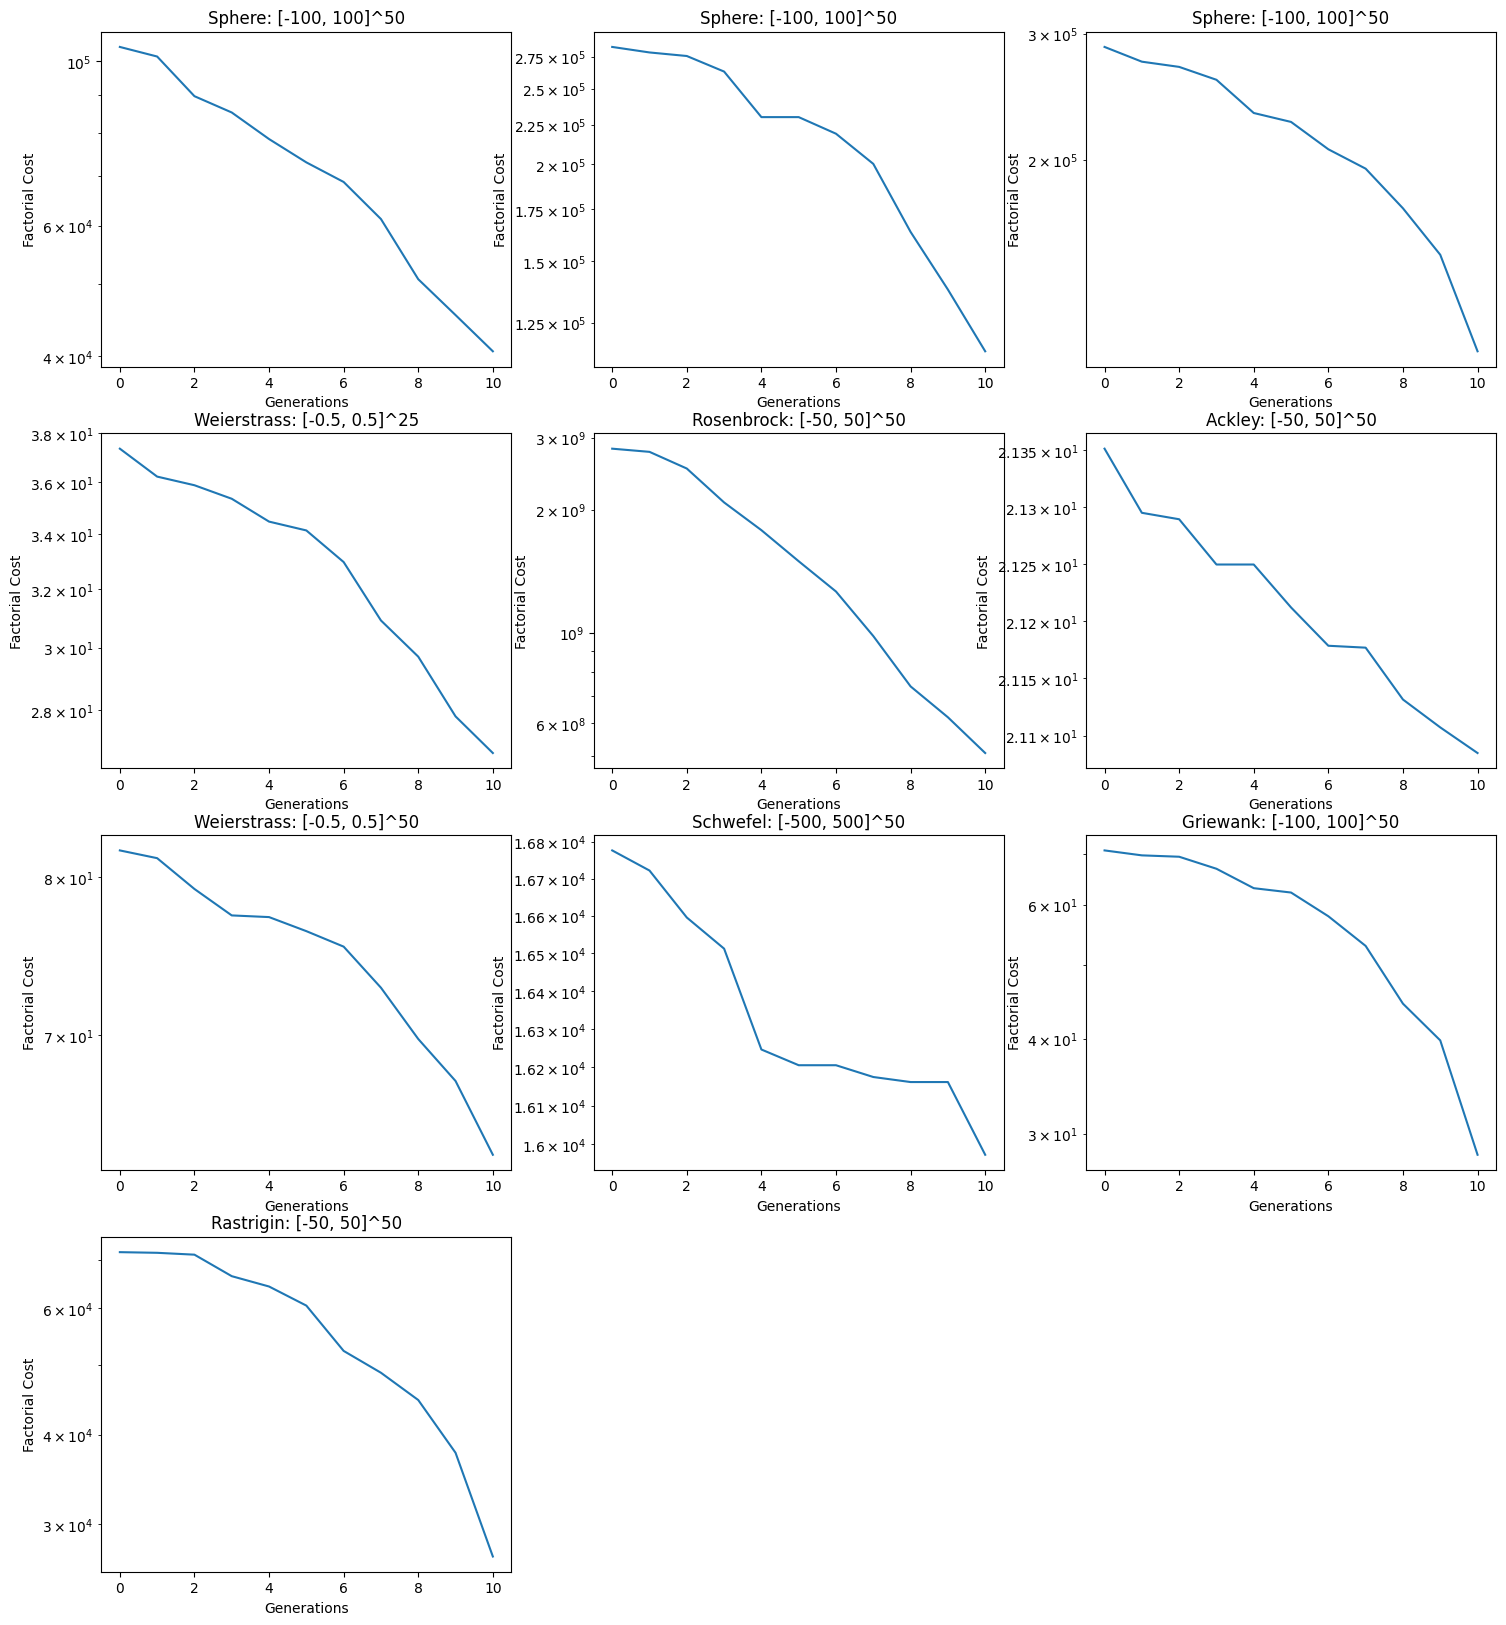

In [3]:
model.render_history(yscale='log')

### Plot History Cost